# Setup and Load Model

In [ ]:
!pip install -U huggingface_hub
!pip install transformers emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer, default_data_collator,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import sys
sys.path.append('../../src')
from min_preprocessing import FinancialTweetPreprocessor
from evaluation_transformer import evaluate_transformer
from initial_balanced_dataset import create_balanced_dataset

from huggingface_hub import list_repo_files, snapshot_download
import time

from torch.nn.functional import softmax
from tqdm.auto import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print("\nCREATING CUSTOM MODEL WITH METADATA FEATURES")
class FinBERTWithMetadata(nn.Module):
    def __init__(self, lora_model, num_features=4, num_labels=3):
        super().__init__()
        self.lora_model = lora_model
        self.dropout = nn.Dropout(0.1)
        # Combine BERT hidden size (768) with metadata features
        self.classifier = nn.Linear(768 + num_features, num_labels)

    def forward(self, input_ids, attention_mask, features=None):
        # Get BERT outputs
        bert_outputs = self.lora_model.base_model.model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get pooled output
        pooled_output = bert_outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # If features provided, concatenate them
        if features is not None:
            combined = torch.cat([pooled_output, features], dim=1)
            logits = self.classifier(combined)
        else:
            # Fallback for inference without features
            logits = self.classifier(pooled_output)

        return logits

# Custom dataset class that includes features
class TextAndFeaturesDataset(Dataset):
    def __init__(self, encodings, labels, features):
        self.encodings = encodings
        self.labels = labels
        self.features = features

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

    def tokenize_function(texts):
        return tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128
        )

print("SETTING UP CUSTOM TRAINER")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        features = inputs.pop("features")

        # Forward pass with features
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            features=features
        )

        # Compute loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(outputs.view(-1, 3), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        labels = inputs.pop("labels") if "labels" in inputs else None
        features = inputs.pop("features")

        with torch.no_grad():
            outputs = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                features=features
            )

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(outputs.view(-1, 3), labels.view(-1))

        return (loss, outputs, labels)


CREATING CUSTOM MODEL WITH METADATA FEATURES
SETTING UP CUSTOM TRAINER


In [ ]:
!mkdir hf_cache

In [ ]:
# 1. Download HuggingFace Weights
from huggingface_hub import list_repo_files, hf_hub_download
import os

repo_id   = "Financial-Sentiment-Analysis/model-weights"
cache_dir = "./hf_cache"

prefix = "models/v1-1/baseline/finbert_lora_min_preproc/"

all_files = list_repo_files(repo_id)
target_files = [f for f in all_files if f.startswith(prefix)]

print(f"Found {len(target_files)} files to download:")
print("\n".join(target_files))

local_paths = []
for f in target_files:
    local_path = hf_hub_download(
        repo_id=repo_id,
        filename=f,
        cache_dir=cache_dir
    )
    local_paths.append(local_path)

model_dir = os.path.commonpath(local_paths)
print("Resolved model_dir:", model_dir)
print("Contents:", os.listdir(model_dir))

Found 8 files to download:
models/v1-1/baseline/finbert_lora_min_preproc/lora_adapter/README.md
models/v1-1/baseline/finbert_lora_min_preproc/lora_adapter/adapter_config.json
models/v1-1/baseline/finbert_lora_min_preproc/lora_adapter/adapter_model.safetensors
models/v1-1/baseline/finbert_lora_min_preproc/model_complete.pth
models/v1-1/baseline/finbert_lora_min_preproc/special_tokens_map.json
models/v1-1/baseline/finbert_lora_min_preproc/tokenizer.json
models/v1-1/baseline/finbert_lora_min_preproc/tokenizer_config.json
models/v1-1/baseline/finbert_lora_min_preproc/vocab.txt


README.md:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

model_complete.pth:   0%|          | 0.00/449M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Resolved model_dir: hf_cache/models--Financial-Sentiment-Analysis--model-weights/snapshots/2ee95464b13b9bac57983b309302b877c9527959/models/v1-1/baseline/finbert_lora_min_preproc
Contents: ['special_tokens_map.json', 'lora_adapter', 'model_complete.pth', 'vocab.txt', 'tokenizer_config.json', 'tokenizer.json']


In [ ]:
# 2. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [ ]:
# 3. Reload the state-dict bundle
ckpt = torch.load(os.path.join(model_dir, "model_complete.pth"), map_location="cpu", weights_only=False)
model_state    = ckpt["model_state_dict"]
scaler         = ckpt["scaler"]
feature_columns   = ckpt["feature_columns"]   # e.g. ['ticker_count','mention_count','url_count','token_count']
lora_config    = ckpt["lora_config"]

In [ ]:
# 4. Load base and LoRA models exactly as in training
base_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3,
)
base_model = prepare_model_for_kbit_training(base_model)

lora_model = get_peft_model(base_model, lora_config)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
model = FinBERTWithMetadata(
    lora_model,
    num_features=len(feature_columns),
    num_labels=3
)
model.load_state_dict(model_state)
model.eval()
model.to("cuda")

FinBERTWithMetadata(
  (lora_model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): BertForSequenceClassification(
        (bert): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                   

In [ ]:
# 5. Quick Evaluation on Test Set

# Load the data
df = pd.read_csv('../../dataset/initial_balanced_tweets.csv')
df_test = pd.read_csv("../../dataset/test_set.csv")

# Preprocess
preprocessor = FinancialTweetPreprocessor()
df_preprocessed = preprocessor.preprocess_dataset(df, 'tweet')
df_test = preprocessor.preprocess_dataset(df_test, text_column='tweet')

# Split data
X = df_preprocessed[['processed_text', 'ticker_count', 'mention_count','url_count', 'token_count']]
y = df_preprocessed['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_test = df_test[['processed_text', 'ticker_count', 'mention_count', 'url_count', 'token_count']]
y_test = df_test['sentiment']

train_features = X_train[feature_columns].values
val_features = X_val[feature_columns].values
test_features = X_test[feature_columns].values

# Scale metadata features
train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

# Tokenize
print("\nTokenizing text data...")
train_encodings = tokenize_function(X_train['processed_text'].tolist())
val_encodings = tokenize_function(X_val['processed_text'].tolist())
test_encodings = tokenize_function(X_test['processed_text'].tolist())

# Build HF datasets
train_dataset = TextAndFeaturesDataset(train_encodings, y_train.tolist(), train_features_scaled)
val_dataset = TextAndFeaturesDataset(val_encodings, y_val.tolist(), val_features_scaled)
test_dataset = TextAndFeaturesDataset(test_encodings, y_test.tolist(), test_features_scaled)

print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

# Setup Trainer
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    seed=42,
    logging_strategy="epoch",
    eval_strategy="epoch",
    logging_dir="./",
    save_strategy="epoch",
    disable_tqdm=True,
    report_to="none",
    remove_unused_columns=False,
)

trainer = CustomTrainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)


Tokenizing text data...
Training set size: 37684 samples
Validation set size: 9422 samples
Test set size: 4998 samples


In [ ]:
# Predict on Test Set
pred_out = trainer.predict(test_dataset)
y_pred  = np.argmax(pred_out.predictions, axis=1)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)

# Get macr-avg metrics
report = classification_report(
    y_test,
    y_pred,
    output_dict=True,
    zero_division=0
)

macro_prec  = report["macro avg"]["precision"]
macro_rec   = report["macro avg"]["recall"]
macro_f1    = report["macro avg"]["f1-score"]

print(f"Test Accuracy       : {acc: .4f}")
print(f"Macro Precision     : {macro_prec: .4f}")
print(f"Macro Recall        : {macro_rec: .4f}")
print(f"Macro F1-Score      : {macro_f1: .4f}")

Test Accuracy       :  0.7741
Macro Precision     :  0.7771
Macro Recall        :  0.7741
Macro F1-Score      :  0.7743


# Generate Pseudolabels

In [ ]:
UNLABELED_FILE_PATH = '../../dataset/tweets_remaining_09042020_16072020.csv'
CONFIDENCE_THRESHOLD=0.90

In [ ]:
unlabeled_df = pd.read_csv(
        UNLABELED_FILE_PATH,
        sep=';',
        on_bad_lines='warn'
    )

# --- Preprocess the ENTIRE DataFrame ---

print("--- Starting Full Processing Run on All Available Unlabeled Data ---")
print(f"Preprocessing all {len(unlabeled_df):,} tweets...")
start_time = time.time()

# Clean out any empty/NaN rows
print(f"Initial rows: {len(unlabeled_df):,}")

unlabeled_df.dropna(subset=['full_text'], inplace=True)
unlabeled_df['full_text'] = unlabeled_df['full_text'].str.strip()
unlabeled_df.replace({'full_text': {'' : float('nan')}}, inplace=True)
unlabeled_df.dropna(subset=['full_text'], inplace=True)
unlabeled_df.reset_index(drop=True, inplace=True)

print(f"Rows after cleaning: {len(unlabeled_df):,}")

# --- Run the Preprocessor ---
processed_full_df = preprocessor.preprocess_dataset(unlabeled_df, text_column='full_text')
end_time = time.time()

print(f"Preprocessing completed in {(end_time - start_time)/60:.2f} minutes.")

--- Starting Full Processing Run on All Available Unlabeled Data ---
Preprocessing all 923,673 tweets...
Initial rows: 923,673
Rows after cleaning: 923,673
Preprocessing completed in 6.91 minutes.


  0%|          | 0/903 [00:00<?, ?it/s]

Generated 345,609 pseudo-labels at ≥90% confidence.

Class distribution:
sentiment
1    131951
0    119398
2     94260
Name: count, dtype: int64


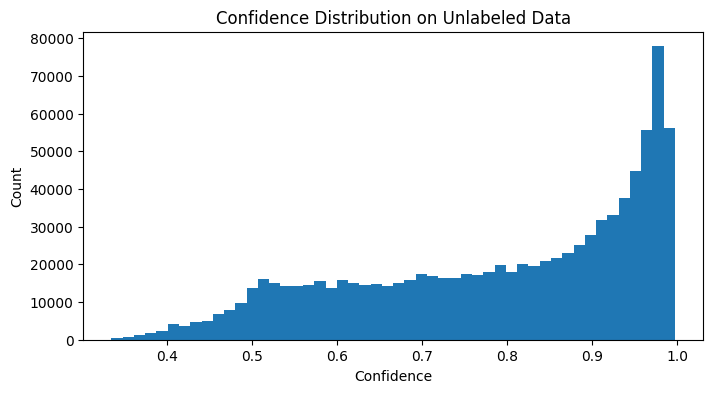

In [ ]:
# Prepare inputs
texts = processed_full_df["processed_text"].tolist()
metas  = processed_full_df[feature_columns].values
metas_scaled = scaler.transform(metas)

batch_size = 1024
all_probs = []

# Batch-wise inference
model.eval()
for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i : i + batch_size]
    batch_meta  = metas_scaled[i : i + batch_size]

    # Tokenize
    inputs = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to("cuda")

    # Metadata tensor
    feats = torch.tensor(batch_meta, dtype=torch.float32, device="cuda")

    # Forward pass
    with torch.no_grad():
        logits = model(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            features=feats
        )

    # Softmax → probabilities
    probs = softmax(logits, dim=-1).cpu().numpy()
    all_probs.append(probs)

probabilities_full = np.vstack(all_probs)  # shape (N, 3)

# Apply confidence threshold to get pseudo-labels
confidences = probabilities_full.max(axis=1)
preds       = probabilities_full.argmax(axis=1)

mask = confidences >= CONFIDENCE_THRESHOLD
pseudo_df = processed_full_df.loc[mask].copy()
pseudo_df["sentiment"]  = preds[mask]
pseudo_df["confidence"] = confidences[mask]

print(f"Generated {len(pseudo_df):,} pseudo-labels at ≥90% confidence.\n")
print("Class distribution:")
print(pseudo_df["sentiment"].value_counts())

# Plot overall confidence histogram
plt.figure(figsize=(8,4))
plt.hist(confidences, bins=50)
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution on Unlabeled Data")
plt.show()

In [ ]:
thresholds = [0.99, 0.98, 0.97, 0.96, 0.95]
yield_counts = []

for thresh in thresholds:
    # Calculate cumulative count
    count = np.sum(confidences >= thresh)
    yield_counts.append(count)

yield_curve_df = pd.DataFrame({
    'Confidence Threshold': thresholds,
    'Labels Generated (Cumulative)': yield_counts
})

print("--- Yield Curve ---")
print(yield_curve_df)

--- Yield Curve ---
   Confidence Threshold  Labels Generated (Cumulative)
0                  0.99                          13826
1                  0.98                          81737
2                  0.97                         136373
3                  0.96                         179981
4                  0.95                         215520


In [ ]:
# Training set size: 37684 samples
# Validation set size: 9422 samples
# Test set size: 4998 samples

# Save all pseudo-labels at ≥98% confidence
threshold = 0.98
mask = confidences >= threshold

pseudo = processed_full_df.loc[mask].copy()
pseudo["sentiment"]  = preds[mask]
pseudo["confidence"] = confidences[mask]

print(f"Labels ≥{threshold*100:.0f}% confidence: {len(pseudo):,}")
print(pseudo["sentiment"].value_counts())

# Save to CSV
OUT_PATH = f"../../dataset/pseudo_labels_{threshold*100:.0f}pct_confidence.csv"
pseudo.to_csv(OUT_PATH, index=False)
print(f"Saved ≥{threshold*100:.0f}%‐confidence pseudo-labels to {OUT_PATH}")

Labels ≥98% confidence: 81,737
sentiment
2    31955
1    28382
0    21400
Name: count, dtype: int64
Saved ≥98%‐confidence pseudo-labels to /content/drive/MyDrive/FNLP/dataset/pseudo_labels_98pct_confidence.csv


In [ ]:
# Load pseudo-labels
df_pseudo = pd.read_csv('../../dataset/pseudo_labels_98pct_confidence.csv')

# Rename Column
pseudo_for_training = (
    df_pseudo[["full_text", "sentiment"]]
      .rename(columns={"full_text": "tweet"})
)

# Overwrite existing file:
pseudo_for_training.to_csv(
    "../../dataset/pseudo_labels_98pct_confidence.csv",
    index=False
)

print("✅ Saved", len(pseudo_for_training), "pseudo-labels with columns:",
      list(pseudo_for_training.columns))


✅ Saved 81737 pseudo-labels with columns: ['tweet', 'sentiment']
